# CAMMAC https://cammac.readthedocs.io
S.Sénési for Météo-France - sept 2019 to march 2021


## Basic notebook for creating a map of the change in a variable between a reference period and a projection period

## Parameters stand in first cell, are either commented here or in the doc (see above)

In [1]:
from __future__ import print_function

In [9]:
import os
do_test                = True

# Scheme for robustness hatching
scheme                 = "KS" # KS for Knutti and Sedlacek 2013, or AR6S for AR6 simplified scheme
threshold              = 0.9 # Used for both schemes

version                = ""     

project                = "CMIP6"
data_versions_tag      = "20210201_derived"
data_versions_dir      = os.getenv("CAMMAC")+"/data"
excluded_models        = []
included_models        = None

variable               = "mrro"
custom_plot            = {}
figure_mask            = None

derivation             = "plain"
season                 = "DJF"
field_type             = "means_rchange"

experiment             = "ssp245"
projection_period      = "2081-2100"
ref_period             = "1995-2014"
ref_experiment         = "historical"

common_grid            = "r360x180"
outdir                 = "./figures"

# Parameters needed by default cammac_user_settings.py
default_fixed_fields_dir = "/data/ssenesi/CAMMAC/data/fixed_fields"
derived_variable_table   = 'yr'
derived_variables_pattern= '/data/ssenesi/CMIP6_derived_variables/${variable}/${variable}_${table}_${model}_${experiment}_${realization}_${grid}_${version}_${PERIOD}.nc'

In [52]:
"e" ==u"e"

True

In [10]:
if do_test :
    if project == "CMIP6 : "
        included_models=["GFDL-CM4", "CNRM-CM6-1","HadGEM3-GC31-LL"]
    elif project == "CMIP5" :
        included_models        = [ "CanESM2", 'MIROC-ESM'] 

In [42]:
# Climaf settings
from climaf.api import *
climaf.cache.stamping=False

from CAMMAClib.figures     import change_figure
from CAMMAClib.ancillary   import feed_dic, choose_regrid_option
from CAMMAClib.mips_et_al  import read_versions_dictionnary, institute_for_model,models_for_experiments
from CAMMAClib.variability import agreement_fraction_on_sign
import CAMMAClib.cancillary

# Load some user settings, if available
settings_file=os.getenv("CAMMAC_USER_PYTHON_CODE_DIR",".")+'/cammac_user_settings.py'
if os.path.exists(settings_file) :
    exec(compile(open(settings_file).read(),settings_file,'exec'))

from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

In [43]:
col40={"colors":"-40 -30 -20 -10 -5   0   5   10  20 30 40 "}
col20={"colors":"-20 -15 -10  -5 -2.5 0 2.5    5  10 15 20 "}
col10={"colors":"-10 -8 -6 -4 -2 0 2 4 6 8 10"}
if custom_plot is None : custom_plot=dict()    
custom_plot.update(col40)

if variable in [ "mrro", "mrso", "mrsos" ] :
    table="Lmon"
    custom_plot["focus"]="land"
    figure_mask = os.getenv("CAMMAC")+"/data/mask_hide_antarctic_360x180.nc"
    if variable == "mrsos" :
        custom_plot.update(col10)
elif variable in [ "drain", "dday" ] :
    table="yr"
    if season != "ANN" :
        raise ValueError("Cannot ask for dday or drain with a season != ANN")
    custom_plot.update({"color":"AR6_Temp_12" , "colors":"-20 -15 -10  -5 -2.5 0 2.5    5  10 15 20 "})
elif variable in [ "sos" ] :
    table="Omon"
    custom_plot.update({"focus":"ocean","colors":"-2.5 -2. -1.5 -1.0 -0.5 0 0.5 1.0 1.5 2.0 2.5 ","color":"AR6_MiscDiv_12"})
    excluded_models.append("IPSL-CM6A-LR")
else :
    table="Amon"
    if variable=="P-E" :
        custom_plot.update({  "min"   : -1, "max"   : 1 , "delta" : 0.2 })
        

In [44]:
data_versions=read_versions_dictionnary(data_versions_tag, data_versions_dir)
model_variants=models_for_experiments(data_versions,variable,table,
                        [ref_experiment,experiment],excluded_models,included_models)

### Compute either yearly seasonal means or seasonal means for all models

In [46]:
dic=dict()
if scheme=="KS" :
    time_averaging="yearavg"
elif scheme=="AR6S":
    time_averaging="timavg"
else :
    raise ValueError("Unknown scheme "+scheme)
    
for model,variant in model_variants :
    grid,version,_=data_versions[ref_experiment][variable][table][model][variant]
    roption=choose_regrid_option(variable,table,model,grid)
    #
    base_dict=dict(project=project, experiment=ref_experiment,
                        model=model, period=ref_period, variable=variable, 
                        table=table, version=version, realization=variant)
    if project=="CMIP6" : 
        dic.update(grid=grid,institute=institute_for_model(model))
    #
    # Compute yearly seasonal mean over requested season
    reference_dict=base_dict.copy()
    reference_ds=ds(**reference_dict)
    #
    seasavg=ccdo(reference_ds,operator=time_averaging+" -selseason,"+season)
    seasavg=regridn(seasavg,cdogrid=common_grid,**roption)
    feed_dic(dic,seasavg,"reference","seasavg",model)
    cfile(seasavg)
    #
    projection_dict=reference_dict.copy()
    _,version,_=data_versions[experiment][variable][table][model][variant]
    projection_dict.update(experiment=experiment,period=projection_period,
                        realization=variant,version=version)
    projection_ds=ds(**projection_dict)
    #
    seasavg=ccdo(projection_ds,operator=time_averaging+" -selseason,"+season)
    seasavg=regridn(seasavg,cdogrid=common_grid,**roption)
    feed_dic(dic,seasavg,"projection","seasavg",model)
    cfile(seasavg)

### Compute either Knutti and Sedlacek robustness index or sign fraction agreement, and derive hatching mask accordingly

In [49]:
refs =cens(dic["reference"] ["seasavg"])
projs=cens(dic["projection"]["seasavg"])

if scheme=="KS":
    k=knutti(refs,projs)
    k=ccdo(k,operator="smooth9 -setmissval,1.e+20")
    
    refs_timavg  = ccdo    (refs,  operator="timavg")
    projs_timavg = ccdo    (projs, operator="timavg")
    
elif scheme=="AR6S" :
    changes=cens()
    for model in refs :
        changes[model]=ccdo2(projs[model],refs[model],operator="sub")
    k=agreement_fraction_on_sign(changes)

    refs_timavg  = refs 
    projs_timavg = projs 

hatch_mask=ccdo(k,operator="lec,%g"%threshold)
    
# Compute relative change on MME mean
refs_mean    = ccdo_ens(refs_timavg, operator='ensmean')
projs_mean   = ccdo_ens(projs_timavg,operator='ensmean')

change  = ccdo2(projs_mean,refs_mean,operator="sub")
rchange = ccdo2(change,refs_mean,operator="mulc,100 -div")    



### Plot relative change hatched with robustness index

In [50]:
if scheme=="KS" :
    pattern="backslashes"
elif scheme=="AR6S" :
    pattern="slashes"
#
name = "%s %s %s %s %s %g"%(experiment,variable,season,projection_period,scheme,threshold)
#
plot = change_figure(variable, derivation, rchange,shade=True,
                mask2=hatch_mask, mask1="",pattern1="",pattern2=pattern,
                relative=("_rchange" in field_type), labelbar="True", 
                title=name, 
                custom_plot=custom_plot, number=len(model_variants),
                mask=figure_mask) 
name = name.replace(" ","_")
f=cfile(plot,"Fig_"+name+".png",ln=True)

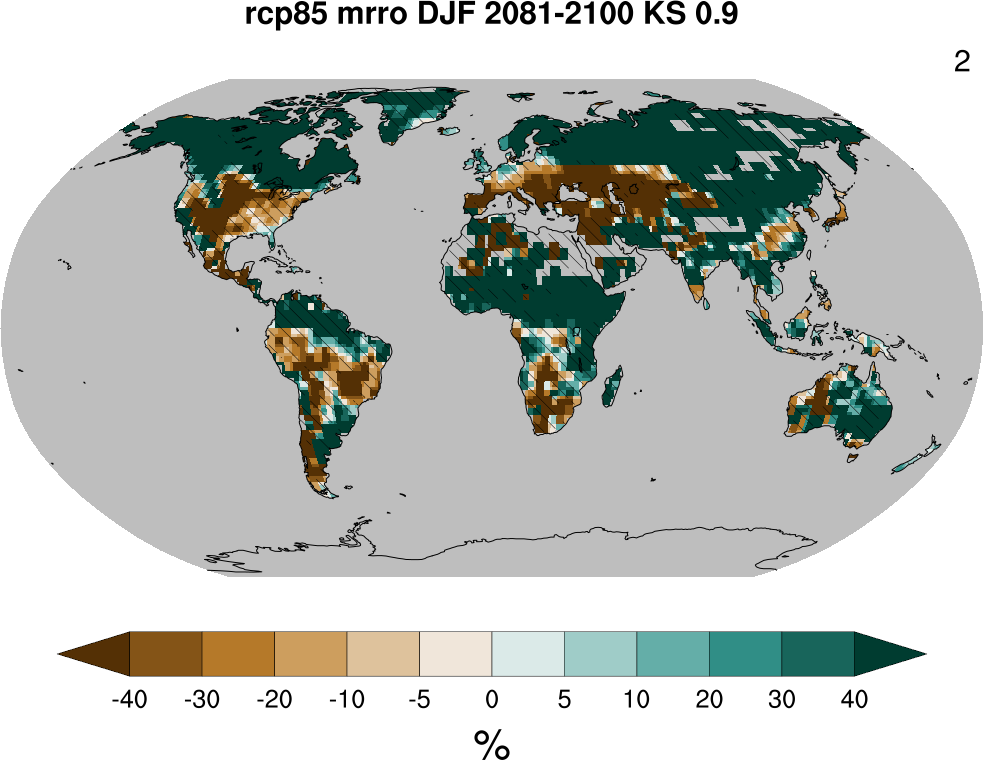

In [51]:
Image(f)